# Proyecto 1: Revisión de sentimientos en comentarios de libros
## Integrantes:
* Natalia Sanabria Forero - 201532265
* Jorge Andrés Esguerra Alarcón - 201719920
* Christian Forigua - 201713023

In [181]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions
!pip install numpy -U
!pip install joblib
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1
!pip install nltk
!pip install sklearn

## 1. Librerías para el procesamiento de texto

In [182]:
# Procesamiento de Lenguaje Natural
import nltk
nltk.download('punkt') # Separar texto en frases
nltk.download('stopwords') # Palabras vacías
nltk.download('wordnet') # Entender el significado de las palabras

# Otras librerías
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/jorgea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jorgea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Perfilamiento y entendimiento de los datos
### Lectura de los datos

In [183]:
data = pd.read_csv('./kindle_reviews.csv')
data.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


### Entendimiento de los datos

In [184]:
data.describe()

,Unnamed: 0,overall,unixReviewTime
count,982619.000000,982619.000000,9.826190e+05
mean,491309.000000,4.347801,1.378183e+09
std,283657.816416,0.955056,2.298476e+07
min,0.000000,1.000000,9.522144e+08
25%,245654.500000,4.000000,1.365206e+09
50%,491309.000000,5.000000,1.383523e+09
75%,736963.500000,5.000000,1.396051e+09
max,982618.000000,5.000000,1.406074e+09


In [185]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978803 non-null  object
 8   summary         982618 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


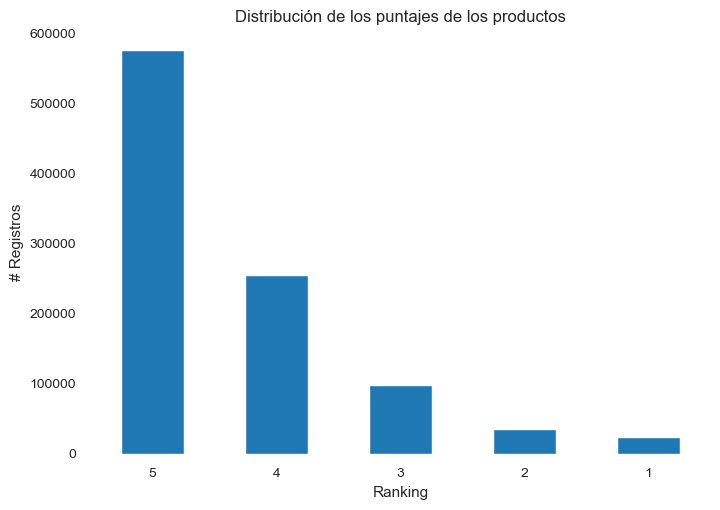

In [186]:
data['overall'].value_counts().plot(kind = 'bar')
plt.title('Distribución de los puntajes de los productos')
plt.xlabel('Ranking')
plt.xticks(rotation = 0)
plt.ylabel('# Registros')
plt.show()

In [187]:
df_data = (data.isna().sum()).to_frame()
df_data.sort_values(0, ascending = False)

,0
reviewerName,3816
reviewText,22
summary,1
Unnamed: 0,0
asin,0
helpful,0
overall,0
reviewTime,0
reviewerID,0
unixReviewTime,0


In [188]:
reviews = data[['reviewText', 'overall','summary']]
df_data = (reviews.isna().sum()).to_frame()
df_data.sort_values(0, ascending = False)

,0
reviewText,22
summary,1
overall,0


In [189]:
reviews.dropna(inplace = True)
reviews

,reviewText,overall,summary
0,I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story
1,This book is a reissue of an old one; the auth...,4,Different...
2,This was a fairly interesting read. It had ol...,4,Oldie
3,I'd never read any of the Amy Brewster mysteri...,5,I really liked it.
4,"If you like period pieces - clothing, lingo, y...",4,Period Mystery
...,...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5,A Hot Read Indeed!!
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5,VERY GOOD BOOK
982616,Great book! Cherika was a fool. She let that m...,5,Great Read
982617,When I say this was an excellent book please b...,5,Wow!!


## 3. Preparación de los datos
### 3.1 Limpieza de los datos

In [190]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word)
        #if word.isdigit():
            #new_word = p.number_to_words(word)
            #new_words.append(new_word)
        #else:
            #new_words.append(word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(word.lower())
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stop_words = set(stopwords.words('english'))
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2 Tokenización

In [191]:
# Se preparan los reviews para la tokenización
reviews['reviewText'] = reviews['reviewText'].apply(contractions.fix)
reviews['summary'] = reviews['summary'].apply(contractions.fix)
reviews

,reviewText,overall,summary
0,I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story
1,This book is a reissue of an old one; the auth...,4,Different...
2,This was a fairly interesting read. It had ol...,4,Oldie
3,I would never read any of the Amy Brewster mys...,5,I really liked it.
4,"If you like period pieces - clothing, lingo, y...",4,Period Mystery
...,...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5,A Hot Read Indeed!!
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5,VERY GOOD BOOK
982616,Great book! Cherika was a fool. She let that m...,5,Great Read
982617,When I say this was an excellent book please b...,5,Wow!!


Se decidió guardar la columna "summary" ya que podría aportar información a la representación de los reviews. Para verificar lo anterior, se va a crear una representación que solo tiene en cuenta la columna "reviewText" y otra que va tener las columnas "reviewText" y "Summary" concatenadas.

In [177]:
#reviews_summary = reviews.copy()
#reviews_summary['reviewText'] = reviews_summary['reviewText'] + ' ' + reviews_summary['summary']
#reviews_summary = reviews_summary[['reviewText', 'overall']]
reviews = reviews[['reviewText', 'overall']]
reviews

,reviewText,overall
0,I enjoy vintage books and movies so I enjoyed ...,5
1,This book is a reissue of an old one; the auth...,4
2,This was a fairly interesting read. It had ol...,4
3,I would never read any of the Amy Brewster mys...,5
4,"If you like period pieces - clothing, lingo, y...",4
...,...,...
982614,Yasss hunny! This is a great read. That Dre is...,5
982615,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,5
982616,Great book! Cherika was a fool. She let that m...,5
982617,When I say this was an excellent book please b...,5


In [178]:
#reviews_summary['words'] = reviews_summary['reviewText'].apply(word_tokenize).apply(preprocessing)
reviews['words'] = reviews['reviewText'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
reviews.head()

,reviewText,overall,words
0,I enjoy vintage books and movies so I enjoyed ...,5,"[enjoy, vintage, books, movies, enjoyed, readi..."
1,This book is a reissue of an old one; the auth...,4,"[book, reissue, old, one, author, born, 1910, ..."
2,This was a fairly interesting read. It had ol...,4,"[fairly, interesting, read, old, style, termin..."
3,I would never read any of the Amy Brewster mys...,5,"[would, never, read, amy, brewster, mysteries,..."
4,"If you like period pieces - clothing, lingo, y...",4,"[like, period, pieces, clothing, lingo, enjoy,..."


In [ ]:
reviews.head()

### 3.3 Normalización

In [179]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    lancaster=LancasterStemmer()
    new_words =[]
    for word in words:
        new_words.append(lancaster.stem(word))
    return new_words    

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    new_words =[]
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    return new_words  

def delete_duplicates(words):
    rta = list(set(words))
    return rta

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    total = stems + lemmas
    return delete_duplicates(total)

In [180]:
reviews['words'] = reviews['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
#reviews_summary['words'] = reviews_summary['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
reviews.head()

KeyboardInterrupt: 

In [ ]:
reviews.sample(3)

In [ ]:
#reviews_summary.sample(3)

### Selección y preparación de los datos

In [ ]:
# Se toma como un sentimiento positivo 4 y 5. Para los valores de 3,2 y 1 se entiende que el sentimiento es negativo. Para el sentimiento
# positivo se toma el label de 1 y para el sentimiento negativo se toma la entrada de 0.
def sentimiento_binario(score):
    if(score <=3):
        return 0
    else:
        return 1

reviews["binary_feeling_score"] = reviews.overall.apply(sentimiento_binario)
#reviews_summary["binary_feeling_score"] = reviews_summary.overall.apply(sentimiento_binario)
reviews.head(5)

In [ ]:
reviews['overall'].value_counts().plot(kind = 'bar')
plt.title('Distribución de los puntajes de los productos')
plt.xlabel('Overall')
plt.xticks(rotation = 0)
plt.ylabel('# Registros')
plt.show()

#### Finalmente, eliminamos la columna overall dado que fue mappeada a binary_feeling_score y no debería usarse como variable predictora. Queremos clasificar solo a base de palabras.

In [ ]:
reviews = reviews.drop(axis=1, columns=["overall, reviewText"])


In [ ]:
reviews.info(verbose=True)

#### Como cada texto ahora es un arreglo de palabras (columna words), es necesario volver a unirlos para poder aplicar el countVectorizer sobre el corpus de cada texto después del procesamiento (limpieza). 

In [165]:
final_reviews = reviews["words"].copy().apply(lambda arr: " ".join(arr))
reviews["words"] = final_reviews.copy()
reviews["final_text"] = reviews["words"].copy()
reviews.drop(axis=1, columns=["words"])

,binary_feeling_score,final_text
0,1,t h i n k s e l f d e f e n s m o v y g ...
1,1,e x p l a i n 1 9 1 0 s a y g o o d e ...
2,1,t e r m i n o l o g y i c h e c k l a n g ...
3,1,o n e n e v e r r e a d r e a l a m y ...
4,1,g u e s s i n g l i n g o l i k e a u t ...
...,...,...
982614,1,t h i n k m e s s g o j o b l o v e ...
982615,1,p o s i t i o n f a r s t r a i g h t v ...
982616,1,t h i n k a w a y g r e a t m a n y l ...
982617,1,l o v e s a y l o v t u r n e r e x c ...


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews["words"])

#x_train,x_test,y_train,y_test = train_test_split(reviews.reviewText,reviews.binary_feeling_score , random_state = 0)

## 4. Construcción de los modelos

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### 4.1 MultinomialNB

### 4.2 LogisticRegression

### 4.3 RandomForestClassifier - Elaboró: Jorge Esguerra

In [160]:
X[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [139]:
vectorizer = CountVectorizer()

X_train_vec = x_train
X_test_vec = x_test
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(rf.score(X_train_vec,y_train),4))
print("Train Score: ", round(rf.score(X_test_vec,y_test),4))

ValueError: could not convert string to float: 'The book sounded interesting so I purcased it blind. I normally wait until there is at least one review.  At first, I regretted my purchase.  I soldiered on and kept readingAfter a few chapters, I was hooked.  I loved the characters, the dialog, the story, the action, and the intrigue. One of my favorite books of the last decade.More please!!!!!!!!!'